In [1]:
!pip install kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ayasquallihoussaini","key":"2a0a06840c3d4f417d08028de774744f"}'}

In [2]:
import os
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
#Import dataset
!kaggle datasets download -d mkashifn/nbaiot-dataset

Dataset URL: https://www.kaggle.com/datasets/mkashifn/nbaiot-dataset
License(s): unknown
 99% 1.74G/1.75G [00:15<00:00, 135MB/s]
100% 1.75G/1.75G [00:15<00:00, 119MB/s]


In [4]:
!unzip nbaiot-dataset.zip -d content

Archive:  nbaiot-dataset.zip
  inflating: content/1.benign.csv    
  inflating: content/1.gafgyt.combo.csv  
  inflating: content/1.gafgyt.junk.csv  
  inflating: content/1.gafgyt.scan.csv  
  inflating: content/1.gafgyt.tcp.csv  
  inflating: content/1.gafgyt.udp.csv  
  inflating: content/1.mirai.ack.csv  
  inflating: content/1.mirai.scan.csv  
  inflating: content/1.mirai.syn.csv  
  inflating: content/1.mirai.udp.csv  
  inflating: content/1.mirai.udpplain.csv  
  inflating: content/2.benign.csv    
  inflating: content/2.gafgyt.combo.csv  
  inflating: content/2.gafgyt.junk.csv  
  inflating: content/2.gafgyt.scan.csv  
  inflating: content/2.gafgyt.tcp.csv  
  inflating: content/2.gafgyt.udp.csv  
  inflating: content/2.mirai.ack.csv  
  inflating: content/2.mirai.scan.csv  
  inflating: content/2.mirai.syn.csv  
  inflating: content/2.mirai.udp.csv  
  inflating: content/2.mirai.udpplain.csv  
  inflating: content/3.benign.csv    
  inflating: content/3.gafgyt.combo.csv  
  inf

In [5]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, make_scorer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [6]:
#Testing for only one device (4 for example)
benign = pd.read_csv('content/4.benign.csv')
combo = pd.read_csv('content/4.gafgyt.combo.csv')
junk = pd.read_csv('content/4.gafgyt.junk.csv')
g_scan = pd.read_csv('content/4.gafgyt.scan.csv')
g_tcp = pd.read_csv('content/4.gafgyt.tcp.csv')
g_udp = pd.read_csv('content/4.gafgyt.udp.csv')
m_scan = pd.read_csv('content/4.mirai.scan.csv')
m_ack = pd.read_csv('content/4.mirai.ack.csv')
m_syn = pd.read_csv('content/4.mirai.syn.csv')
m_udp = pd.read_csv('content/4.mirai.udp.csv')
m_udpplain = pd.read_csv('content/4.mirai.udpplain.csv')

In [7]:
# Attack Labels
benign['type'] = 'benign'
combo['type'] = 'gafgyt.combo'
junk['type'] = 'gafgyt.junk'
g_scan['type'] = 'gafgyt.scan'
g_tcp['type'] = 'gafgyt.tcp'
g_udp['type'] = 'gafgyt.udp'
m_scan['type'] = 'mirai.scan'
m_ack['type'] = 'mirai.ack'
m_syn['type'] = 'mirai.syn'
m_udp['type'] = 'mirai.udp'
m_udpplain['type'] = 'mirai.udpplain'

In [8]:
df = pd.concat([benign, combo, junk, g_scan, g_tcp, g_udp, m_scan, m_ack, m_syn,m_udp, m_udpplain], axis=0, ignore_index=True, sort=False)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098677 entries, 0 to 1098676
Columns: 116 entries, MI_dir_L5_weight to type
dtypes: float64(115), object(1)
memory usage: 972.3+ MB


In [9]:
df["type"].value_counts()

,count
type,
mirai.udp,217034
benign,175240
mirai.syn,118128
gafgyt.udp,105782
mirai.scan,103621
gafgyt.tcp,92581
mirai.ack,91123
mirai.udpplain,80808
gafgyt.combo,58152


<Axes: title={'center': 'Class Distribution (Testing for Device 4: Security Camera)'}, xlabel='count', ylabel='type'>

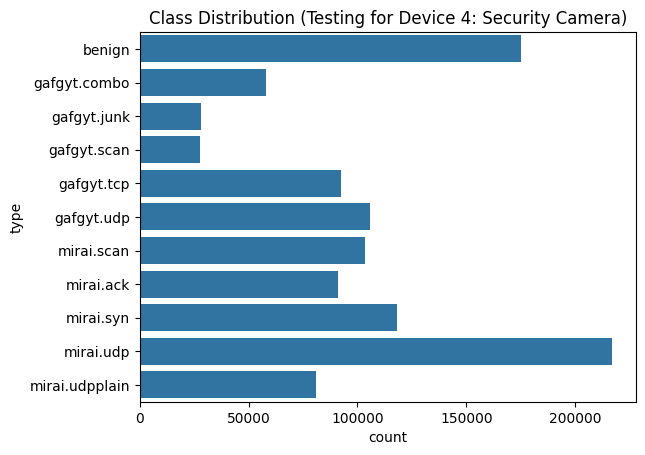

In [11]:
plt.title("Class Distribution (Testing for Device 4: Security Camera)")
sns.countplot(df["type"])

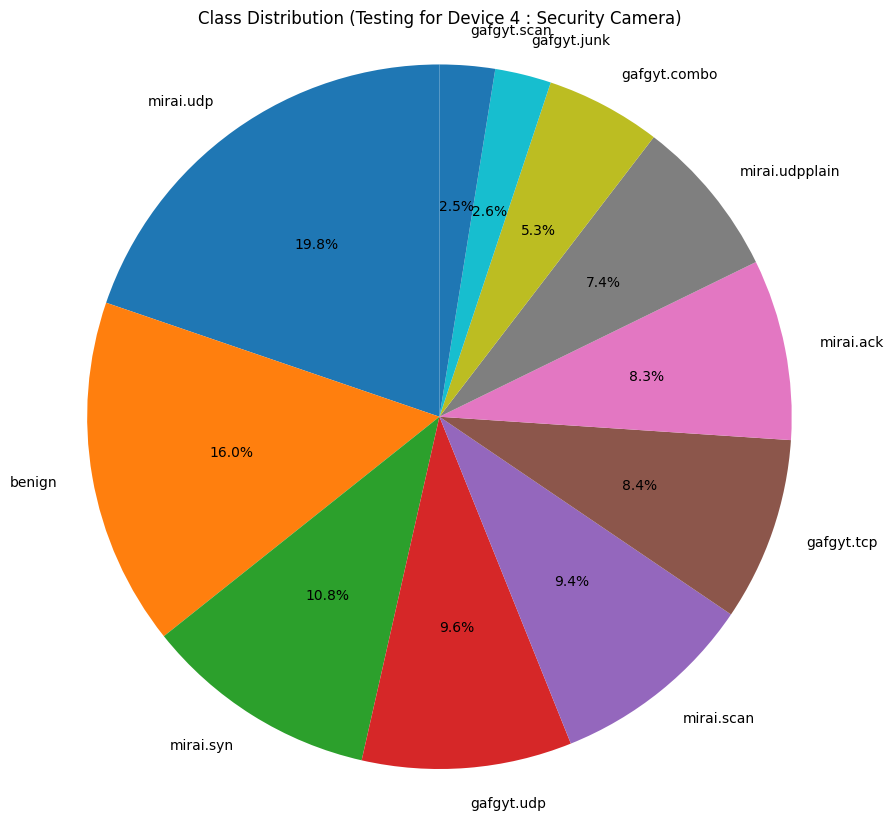

In [12]:
plt.figure(figsize=(10, 10))
plt.title("Class Distribution (Testing for Device 4 : Security Camera)")
df["type"].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.ylabel('')
plt.axis('equal')
plt.show()

**bold text**# PCA

Explained variance ratio (first 10): [0.34914453 0.15006072 0.09627644 0.08164647 0.07268526 0.0343794
 0.02603486 0.02335873 0.02075485 0.01731281]
Cumulative variance explained: 1.0
PCA components kept: 115


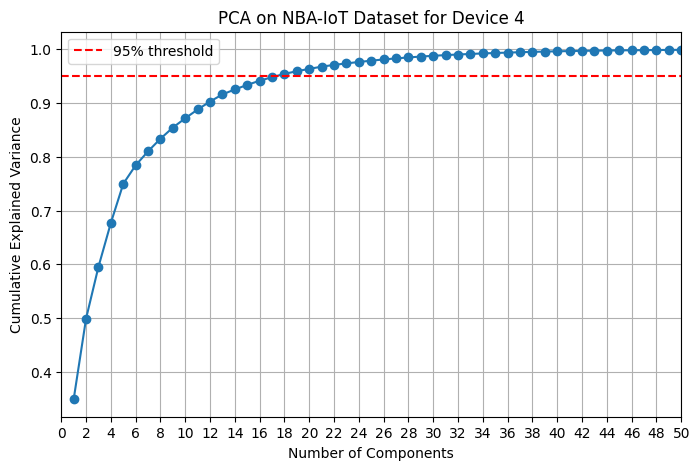

In [13]:
y = df['type']
x = df.drop(columns=['type'])

#Scale features
scaler = StandardScaler()
scaler.fit(x) # Fit only on numerical features
X = scaler.transform(x) # Transform only numerical features

pca = PCA(n_components=None, random_state=0)
X_pca = pca.fit_transform(X)

print("Explained variance ratio (first 10):", pca.explained_variance_ratio_[:10])
print("Cumulative variance explained:", pca.explained_variance_ratio_.sum())
print("PCA components kept:", X_pca.shape[1])

df_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])], index=df.index)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_variance)+1),
         cumulative_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label="95% threshold")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA on NBA-IoT Dataset for Device 4")
plt.xticks(range(0, len(cumulative_variance)+1, 2))

plt.xlim([0, 50])
plt.grid()
plt.legend()
plt.show()

In [14]:
# Smallest k such that C(k) >= 95%
n_components = next(i for i, cv in enumerate(cumulative_variance, 1) if cv >= 0.95)
print("Optimal number of components (95% variance):", n_components)




Optimal number of components (95% variance): 18


In [15]:
pca_opt = PCA(n_components=n_components)
X_reduced = pca_opt.fit_transform(X)

print("Reduced shape:", X_reduced.shape)


Reduced shape: (1098677, 18)


## TSNE

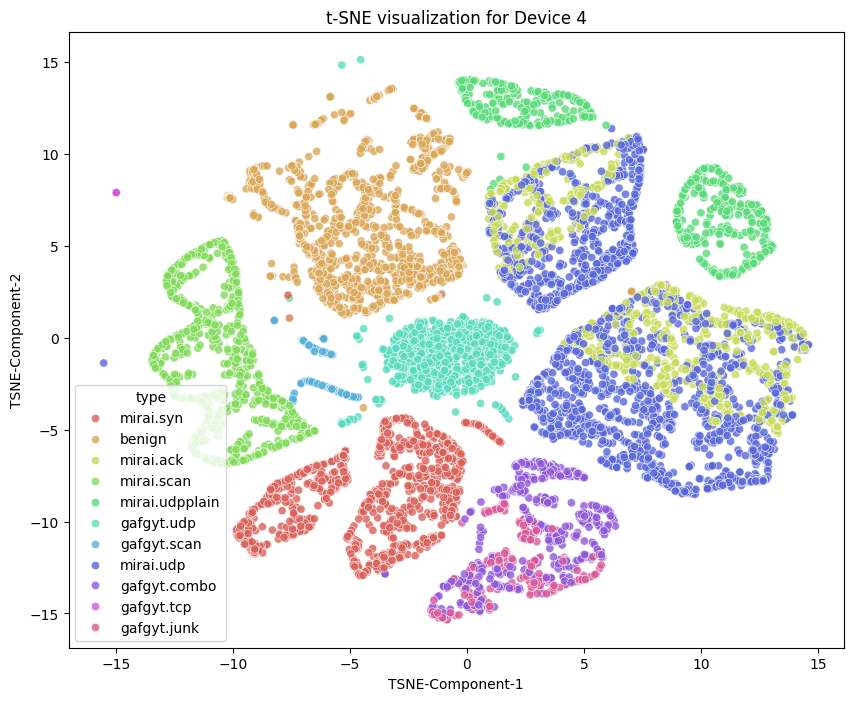

In [16]:

X_device = df.drop(columns=['type'])
y_device = df['type']

# Scale features for the single device data
scaler_device = StandardScaler()
X_scaled_device = scaler_device.fit_transform(X_device)

# Select a subset of the data for t-SNE
# Adjust the fraction or number of samples as needed based on computational resources
subset_size = 10000
if X_scaled_device.shape[0] > subset_size:
    np.random.seed(42) # for reproducibility
    subset_indices = np.random.choice(X_scaled_device.shape[0], subset_size, replace=False)
    X_subset = X_scaled_device[subset_indices]
    y_subset = y_device[subset_indices]
else:
    X_subset = X_scaled_device
    y_subset = y_device


# Perform t-SNE
# Adjust perplexity and n_iter based on your data and desired visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=300)
X_tsne = tsne.fit_transform(X_subset)

# Create a DataFrame for plotting
tsne_df = pd.DataFrame(data=X_tsne, columns=['TSNE-Component-1', 'TSNE-Component-2'])
tsne_df['type'] = y_subset.reset_index(drop=True) # Ensure index aligns

# Visualize the t-SNE results
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="TSNE-Component-1", y="TSNE-Component-2",
    hue="type",
    palette=sns.color_palette("hls", len(y_subset.unique())),
    data=tsne_df,
    legend="full",
    alpha=0.8
)
plt.title('t-SNE visualization for Device 4')
plt.show()

# Random Forest Model

In [17]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.3, random_state=42
)

# Random Forest
rf = RandomForestClassifier(max_depth=10, n_estimators=200, max_features='sqrt', random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Evaluation
#Accuracy Metric
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
#F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)
#Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Accuracy: 0.9874303709906433
F1 Score: 0.9870505314512082

Classification Report:
                 precision    recall  f1-score   support

        benign       1.00      1.00      1.00     52372
  gafgyt.combo       0.87      0.97      0.92     17552
   gafgyt.junk       0.92      0.70      0.79      8525
   gafgyt.scan       1.00      1.00      1.00      8250
    gafgyt.tcp       1.00      1.00      1.00     27863
    gafgyt.udp       1.00      1.00      1.00     31891
     mirai.ack       0.99      0.98      0.99     27445
    mirai.scan       1.00      1.00      1.00     31078
     mirai.syn       1.00      1.00      1.00     35508
     mirai.udp       0.99      0.99      0.99     65097
mirai.udpplain       1.00      0.99      1.00     24023

      accuracy                           0.99    329604
     macro avg       0.98      0.97      0.97    329604
  weighted avg       0.99      0.99      0.99    329604



In [18]:
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Train F1:", f1_score(y_train, y_pred_train, average='weighted'))
print("Test F1:", f1_score(y_test, y_pred_test, average='weighted'))

Train Accuracy: 0.9877878952973255
Test Accuracy: 0.9874303709906433
Train F1: 0.9874044852959483
Test F1: 0.9870505314512082


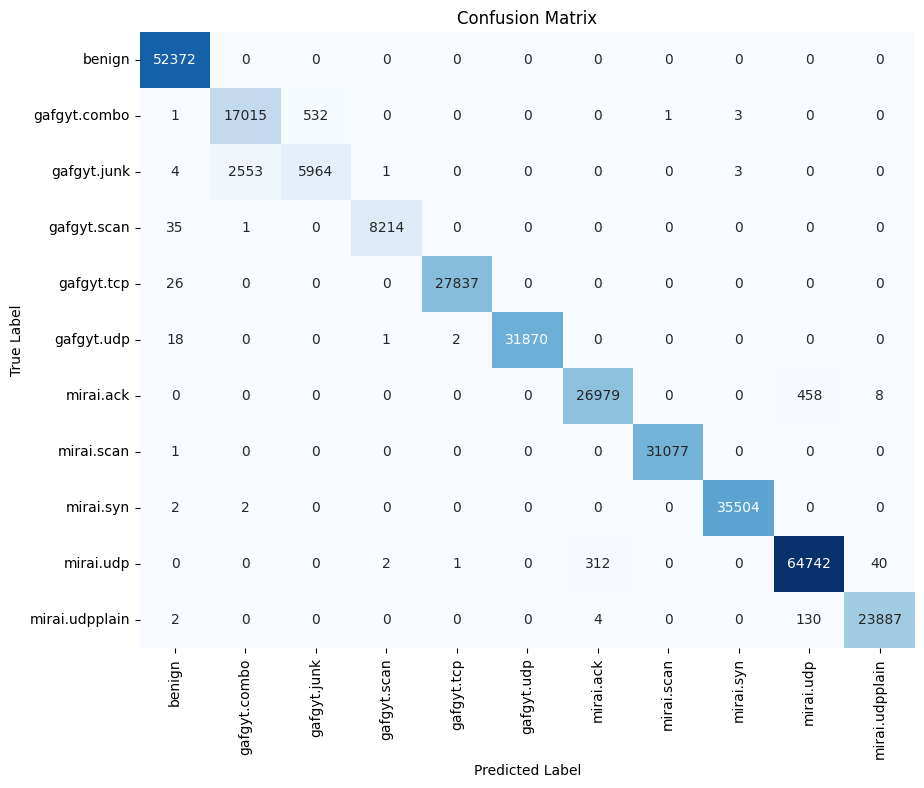

In [19]:
#Confusion Matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Stratified Cross Validation

In [20]:

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# f1_scorer = make_scorer(f1_score, average='weighted')
# accuracy_scorer = make_scorer(accuracy_score)
# # F1 Score
# f1_scores = cross_val_score(rf, X, y, cv=skf, scoring=f1_scorer)
# print("F1 Scores for each fold:", f1_scores)
# print("Mean F1:", np.mean(f1_scores))
# print("Std F1:", np.std(f1_scores))

# # Accuracy
# accuracy_scores = cross_val_score(rf, X, y, cv=skf, scoring=accuracy_scorer)
# print("Accuracy for each fold:", accuracy_scores)
# print("Mean Accuracy:", np.mean(accuracy_scores))
# print("Std Accuracy:", np.std(accuracy_scores))
